In [258]:
# import libs
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.tools.eval_measures import rmse

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
#from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix




In [259]:
# Read dataset file that was donwloaded
#sales_dirty_df = pd.read_csv(filepath_or_buffer='sales_train_v2.csv', sep=',')
sales_train_df = pd.read_csv('sales_train_v2.csv', sep=',',header=0,parse_dates=True)

shops_df = pd.read_csv('shops.csv', sep=',',header=0)
item_category_df = pd.read_csv('item_categories.csv', sep=',',header=0)
items_df = pd.read_csv('items.csv', sep=',',header=0)
test_df = pd.read_csv('test.csv', sep=',',header=0)


In [260]:
# View info()
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [262]:
# Split the date into day, month and year to facilitate deeper interpretation.

raw_date = sales_train_df.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

sales_train_df['day'] = raw_date.dt.day
sales_train_df['month'] = raw_date.dt.month
sales_train_df['year'] = raw_date.dt.year

#sales_train_df.head()

In [265]:
# calculate the sales store per month
sales_train_df['sales']=sales_train_df.item_price*sales_train_df.item_cnt_day

In [267]:
# Add item category to the sales train dataset
sales_train_df = pd.merge(sales_train_df,items_df, on='item_id')
sales_train_df.drop('item_name', axis=1,inplace=True)

In [268]:
new_sales_train=sales_train_df
new_sales_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,sales,item_category_id_x,item_category_id_y,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,2,1,2013,999.0,37,37,37
1,23.01.2013,0,24,22154,999.0,1.0,23,1,2013,999.0,37,37,37
2,20.01.2013,0,27,22154,999.0,1.0,20,1,2013,999.0,37,37,37


In [319]:
# preparing the series for the model
df2 = pd.DataFrame(new_sales_train,columns=['date','sales'])
# convert column date to datetime
df2['date'] = df2['date'].astype('datetime64[ns]')
df2.index = df2.date
#removing null values
df2['sales'] = df2['sales'].fillna(0)
df2 = df2.resample('D').mean()

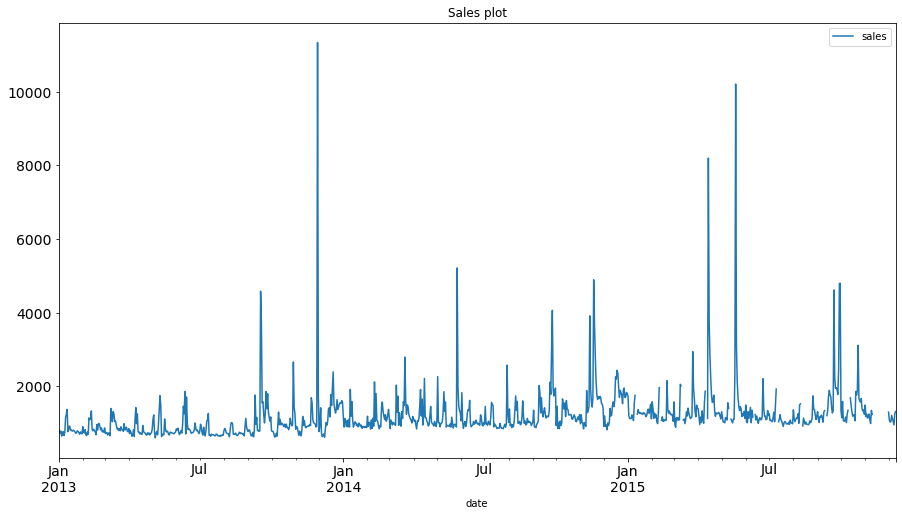

In [308]:
df2.plot(figsize=(15,8), title= 'Sales plot', fontsize=14)
plt.show()
# observation: we can see that the sales is steady throughout the year but has some peaks before January, july

In [320]:
# Check for other odd value due to dicky fuller NAN values 
df2['sales'] = df2['sales'].fillna(0)
df2[df2['sales'].isin([np.nan, np.inf, -np.inf])]

,sales
date,


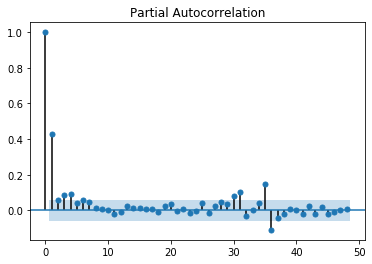

In [337]:
# let's check the partial autocorrelation over a period of 48 months
from statsmodels.graphics.tsaplots import plot_pacf

series = df2
plot_pacf(series, lags=48)
pyplot.show()

In [ ]:
# observation: series is correlated
# the Autocorrelation function for the AR(k) time series is  strong to a lag of k( around 1) and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

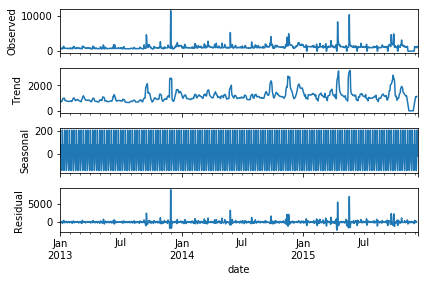

In [348]:
#let decompose the model to series to see if seasonality, trends, noise
from statsmodels.tsa.seasonal import seasonal_decompose
series = df2['sales']
result = seasonal_decompose(series, model='additive')
result.plot()
pyplot.show()


In [ ]:
#observation; the sales are pretty steady thourghout the year except but has some peaks
# no seasonality

In [321]:
# checking for stationarity by running the dickey-fuller test.
# if p static less than critical value then data is stationnary

from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(df2['sales'])

Results of Dickey-Fuller Test:
Test Statistic                -8.498983e+00
p-value                        1.253221e-13
#Lags Used                     6.000000e+00
Number of Observations Used    1.067000e+03
Critical Value (1%)           -3.436493e+00
Critical Value (5%)           -2.864253e+00
Critical Value (10%)          -2.568214e+00
dtype: float64


In [ ]:
# P test statistic is less than the critical value, so the series is stationary


Model performance DRAFT(to be adjusted once part 3 is submitted)
using a ARIMA model ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

We will focus on the Sales forecast for the performance

In [323]:
#let estimate my P,d, q values for arima
#p= is num of lag obser,  d=num of time that of the raw obs are differentiated, 
# q is the size of moving average
#%pip install pmdarima
import pmdarima as pm
from pmdarima.arima.utils import ndiffs


y = df2


## Adf Test
print(ndiffs(y, test='adf') ) # 1

# KPSS test
print(ndiffs(y, test='kpss'))  # 0

# PP test:
ndiffs(y, test='pp')  # 1

0
1


0

In [327]:
# from that we know that our best ARIMA parameters are 0,1,0 so we can fit the data into it
from statsmodels.tsa.arima_model import ARIMA
from pandas import Series


#  ARIMA Model fit
model = ARIMA(df2.sales, order=(0,1,0))
model_fit = model.fit(disp=0)
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                 1073
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -8650.662
Method:                           css   S.D. of innovations            767.538
Date:                Thu, 05 Dec 2019   AIC                          17305.324
Time:                        15:43:06   BIC                          17315.280
Sample:                    01-02-2013   HQIC                         17309.095
                         - 12-10-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4594     23.431      0.020      0.984     -45.466      46.384
==============================================================================
"""

In [ ]:
#observation:  there is no AR which means that the series is stationnary

In [329]:

#  ARIMA Model with a different order to see different values of error and stdv at different lags
model = ARIMA(df2.sales, order=(5,1,0))
model_fit = model.fit(disp=0)
model_fit.summary()
#summary(model_fit)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                 1073
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8498.456
Method:                       css-mle   S.D. of innovations            665.842
Date:                Thu, 05 Dec 2019   AIC                          17010.911
Time:                        15:51:30   BIC                          17045.759
Sample:                    01-02-2013   HQIC                         17024.110
                         - 12-10-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3878      7.522      0.052      0.959     -14.355      15.131
ar.L1.D.sales    -0.5307      0.030    -17.571      0.000      -0.590      -0.471
ar.L2.D.sales    -0.4605      0.034    -13.704      0.000      -0.526      -0.395
ar.L3.D.sales    -0.3515      0.035    -10.106      0.000      -0.420      -0.283
ar.L4.D.sales    -0.2191      0.034     -6.530      0.000      -0.285      -0.153
ar.L5.D.sales    -0.1444      0.030     -4.790      0.000      -0.203      -0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6780           -1.2165j            1.3926           -0.1691
AR.2            0.6780           +1.2165j            1.3926            0.1691
AR.3           -1.5290           -0.0000j            1.5290           -0.5000
AR.4           -0.6725           -1.3725j            1.5284           -0.3225
AR.5           -0.6725           +1.3725j            1.5284            0.3225
-----------------------------------------------------------------------------
"""

In [ ]:
# observation: P value is more 0.959 is more than our significance level of 0.05
# model is overfitted?

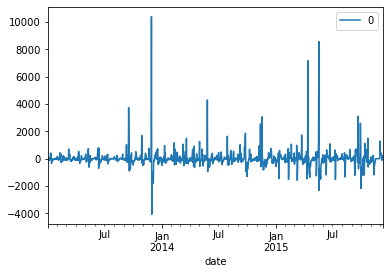

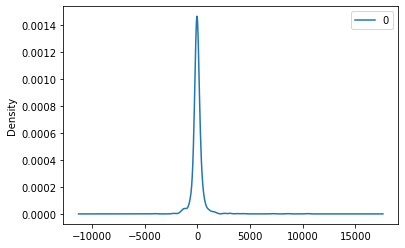

                  0
count   1073.000000
mean      -0.094350
std      666.154137
min    -4071.366242
25%     -161.171121
50%      -33.559933
75%       92.152154
max    10388.855083


In [330]:
# let check our Model residual error
# plot residual errors

from pandas import DataFrame
from matplotlib import pyplot
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

######


In [ ]:
#the residual errors is  near zero mean and uniform variance.
# good sign for the model

predicted=1278.342108, expected=1261.936877
predicted=1262.529840, expected=1232.555460
predicted=1233.108563, expected=1167.930746
predicted=1168.397291, expected=1199.819329
predicted=1200.327548, expected=1326.388387
predicted=1327.063574, expected=1372.849305
predicted=1373.585056, expected=1254.449199
predicted=1255.027570, expected=1367.676225
predicted=1368.403209, expected=1505.031567
predicted=1505.938563, expected=1108.359050
predicted=1108.742914, expected=1571.445789
predicted=1572.437673, expected=1390.788866
predicted=1391.542366, expected=1123.317836
predicted=1123.719797, expected=1265.505952
predicted=1266.093497, expected=1148.760213
predicted=1149.194381, expected=1220.072894
predicted=1220.599593, expected=1019.618094
predicted=1019.882756, expected=978.299075
predicted=978.509592, expected=1302.227216
predicted=1302.858693, expected=1957.459311
predicted=1958.940918, expected=0.000000
predicted=-1.059172, expected=0.000000
predicted=-1.057800, expected=1070.673792


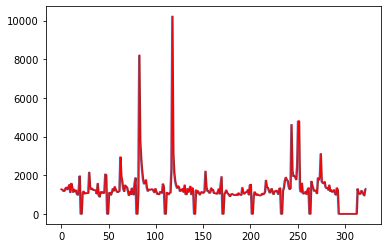

In [333]:
#  Forecast Performance Measure and Metrics Measures

# let evaluate the model performance with  trained data
# we we will also use a 70% of the data training
## we will use 70% of the whole data for training and the remaining 30 % for test

########
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 

 

X = df2.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
#pyplot.plot(test)
#pyplot.plot(predictions, color='red')
#pyplot.show()


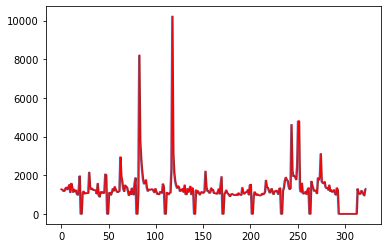

In [349]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

-overall the predicted values are pretty closed to the training 
-the graph( at the end of the long list) shows that the forecast mimics the ---training sample so our model is very good
-MSE means the model is wrong for 707693.141 on sales!  could be that the model is overfitting

conclusion: the Arima time series models use information coming from the time series itself, i.e. coming from the so far observed values. However such models may not be able to see and to model high and low peaks. Hence, we can use either exogenous variables or add dummies to somehow force the model to fine tune at specific times.